# Preparation

In [1]:
import glob
import json
import os
import random

import graphviz
import matplotlib.pyplot as plt
import nilearn.image as nimg
import numpy as np
import pandas as pd
import seaborn as sb
from matplotlib.colors import LinearSegmentedColormap
from nilearn import plotting
from scipy.cluster._optimal_leaf_ordering import squareform
from scipy.cluster.hierarchy import fcluster, linkage
from sklearn import tree
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

from aafm.AAFM_service import AAFMService
from aafm.sample_service import SampleService
from core.correlation_service import CorrelationService
from core.file_service import FileService
from core.postprocess_service import PostprocessService

In [2]:
# load global vars
postproc_srv = PostprocessService()
sample_srv = SampleService()
aafm_srv = AAFMService()
file_srv = FileService()
corr_srv = CorrelationService()
basedir = "/home/ymerel/storage/results/auditory"
mean_path = os.path.join(basedir, 'mean_result.nii')
df_path = os.path.join(basedir, 'dataset.csv')
corr_path = os.path.join(basedir, 'correlations.csv')
ids = []
results = []
paths = glob.glob(os.path.join(basedir, '*/'), recursive=True)
for path in paths:
    ids.append(os.path.basename(os.path.dirname(path)))
    results.append(os.path.join(path, '_subject_id_01', 'result.nii'))

# Show pipeline diagram

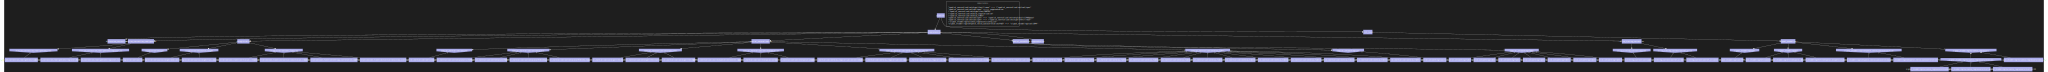

In [3]:
# Load the .dot file
with open('/home/ymerel/fmri-feature-model/model/uvl/full_pipeline.dot', 'r') as file:
    dot_data = file.read()

# Create a Graphviz Source object
src = graphviz.Source(dot_data)

# Render the graph to a file (e.g., PDF, PNG)
src.render('full_pipeline', format='png', cleanup=True)

# Display the graph (if using Jupyter Notebook)
src

# Load dataset
90 features + config hash (id) + correlation from ref + correlation from mean

In [4]:
# Mount group storage
!sshfs -o reconnect,ServerAliveInterval=120,ServerAliveCountMax=3 rennes.g5k:/srv/storage/empenn@storage2.rennes.grid5000.fr/private/ymerel /home/ymerel/storage
# load correlations
correlations = pd.read_csv(corr_path, delimiter=';')
matrix = correlations.pivot(index='source', columns='target', values='correlation').fillna(1.0)
distance_matrix = 1 - matrix

fusermount3: failed to access mountpoint /home/ymerel/storage: Permission denied


In [5]:
# write extended dataset (with mean of correlations, 10 random ref)
# Choose 10 random correlations as refs
def get_extended_dataset():
    unique_values = [value for value in correlations['source'].unique() if value not in ['ref', 'mean']]
    random_refs = random.sample(list(unique_values), 10)
    extended_dataset = pd.read_csv(df_path, delimiter=';')
    for ref in random_refs:
        print(f"Fetching correlations for random ref [{ref}]")
        for index, row in extended_dataset.iterrows():
            id_value = row['id']
            correlation = correlations.loc[
            (correlations['source'] == id_value) &
            (correlations['target'] == ref), 'correlation'].values[0]
            extended_dataset.at[index, f'from_{ref}'] = correlation
    print(f"Calculating mean of correlations for each config")
    for index, row in extended_dataset.iterrows():
            id_value = row['id']
            if id_value == 'ref' or id_value == 'mean':
                continue
            values = correlations.loc[
            (correlations['source'] == id_value) & (correlations['target'] != id_value) & (correlations['target'] != 'ref') & (correlations['target'] != 'mean'), 'correlation'].values
            extended_dataset.at[index, f'mean_corr'] =  sum(values) / len(values)
    # write dataset
    extended_dataset.to_csv(os.path.join(basedir, 'extended_dataset.csv'), index=False, sep=';')

# get_extended_dataset()

In [6]:
def clusterize(ids: list, nb_clusters: int):
    filtered_ds = dataset[dataset['id'].isin(ids)]
    filtered_corr = correlations[correlations['source'].isin(ids) & correlations['target'].isin(ids)]
    filtered_matrix = filtered_corr.pivot(index='source', columns='target', values='correlation').fillna(1.0)
    filtered_distance_matrix = 1 - filtered_matrix
    
    Z = linkage(squareform(filtered_distance_matrix), method='complete')
    clusters = fcluster(Z, nb_clusters, criterion='maxclust')
    
    matrix_df = pd.DataFrame(filtered_distance_matrix)
    matrix_df['cluster'] = clusters
    cluster_centroids = matrix_df.groupby('cluster').mean().mean(axis=1)
    sorted_clusters = cluster_centroids.sort_values().index
    consistent_label_mapping = {old_label: new_label + 1 for new_label, old_label in enumerate(sorted_clusters)}
    consistent_clusters = matrix_df['cluster'].map(consistent_label_mapping)

    mapping = pd.DataFrame({'config': filtered_distance_matrix.index, 'cluster': consistent_clusters})

    for id, row in mapping.iterrows():
        config = row['config']
        cluster = row['cluster']
        filtered_ds.loc[filtered_ds['id'] == config, 'cluster'] = int(cluster)
        
    filtered_ds = filtered_ds.sort_values(by='id', ascending=False)
    return filtered_ds, filtered_matrix, Z

# Clusterize all configurations

cluster
1.0    556
2.0    195
3.0    177
4.0     72
Name: count, dtype: int64


<Figure size 2000x2000 with 0 Axes>

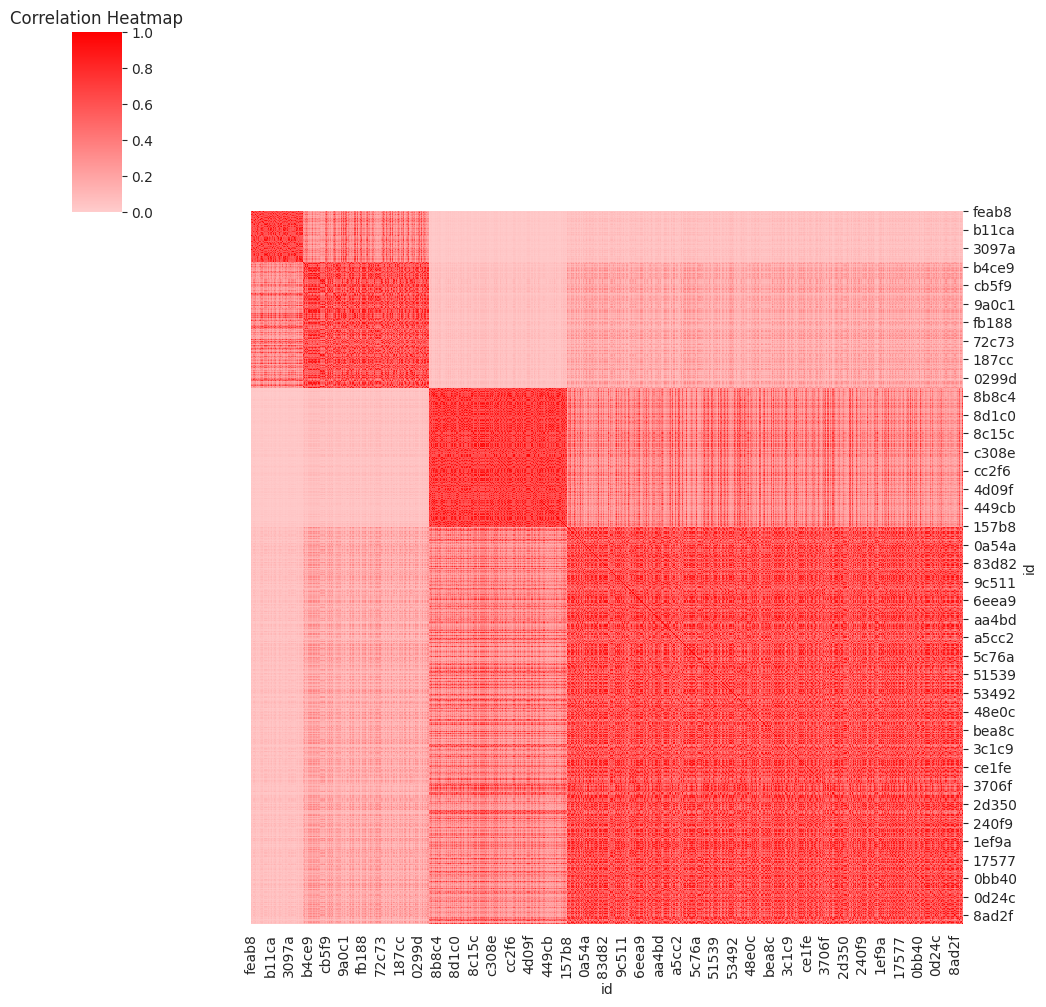

In [7]:
dataset = pd.read_csv(os.path.join(basedir, 'extended_dataset.csv'), delimiter=';').drop(columns=['mean_corr'])
target_vars = [col for col in dataset.columns if col.startswith('from_')]

dataset, matrix, Z = clusterize(dataset["id"], 4)
cluster_counts = dataset['cluster'].value_counts()
print(cluster_counts)
plt.figure(figsize=(20, 20))
cmap = LinearSegmentedColormap.from_list("red_cmap", ["#FFCCCC", "#FF0000"])

# reorder matrix by cluster
sorted_index = dataset.sort_values('cluster', ascending=False)['id']
matrix = matrix.reindex(index=sorted_index, columns=sorted_index)
matrix.index = matrix.index.str.slice(0, 5)
matrix.columns = matrix.columns.str.slice(0, 5)
map = sb.clustermap(matrix, cmap=cmap, vmin=0, vmax=1, row_cluster=False, col_cluster=False, row_linkage=Z, col_linkage=Z)
plt.title('Correlation Heatmap')
plt.show()

# Features repartition
Check features repartition for all configurations vs sample

Retrieved all [27648] configurations from [/home/ymerel/fmri-feature-model/model/uvl/full_pipeline.uvl]


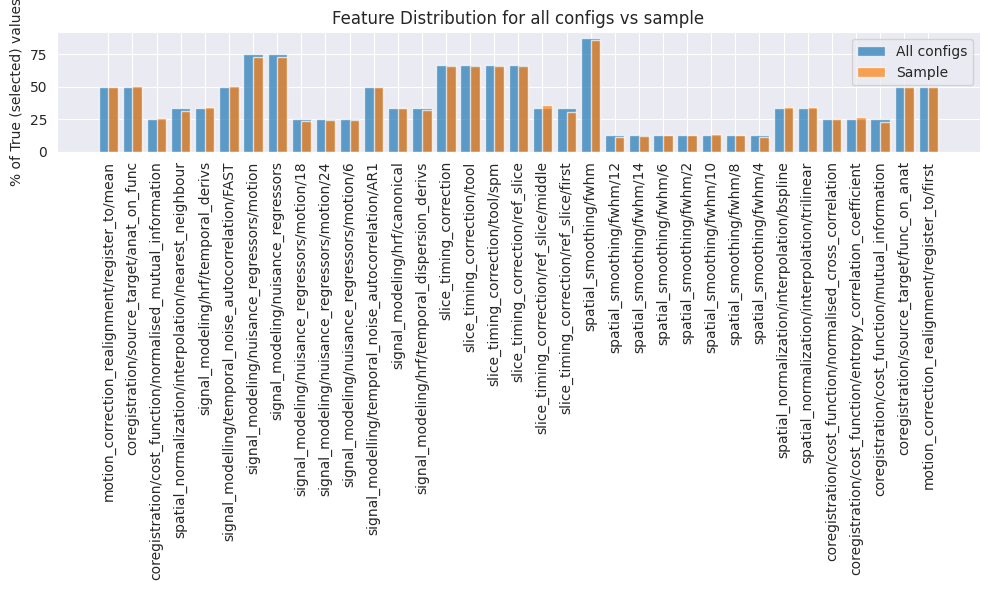

In [8]:
pd.set_option('future.no_silent_downcasting', True)
full = pd.DataFrame(sample_srv.get_all_configs()).fillna(False).astype(bool)
full_rep = full.mean() * 100
full_rep = full_rep[(full_rep > 0) & (full_rep < 100)]
ignored = target_vars.copy()
ignored.append('id')
ignored.append('cluster')
sample_rep = dataset.drop(columns=ignored).mean() * 100
sample_rep = sample_rep[(full_rep > 0) & (sample_rep < 100)]
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the percentages for df1
ax.bar(full_rep.index, full_rep, alpha=0.7, label='All configs')

# Plot the percentages for df2
ax.bar(sample_rep.index, sample_rep, alpha=0.7, label='Sample', align='edge', width=0.4)

# Add labels and title
ax.set_ylabel('% of True (selected) values')
ax.set_title('Feature Distribution for all configs vs sample')
ax.legend()

# Show plot
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

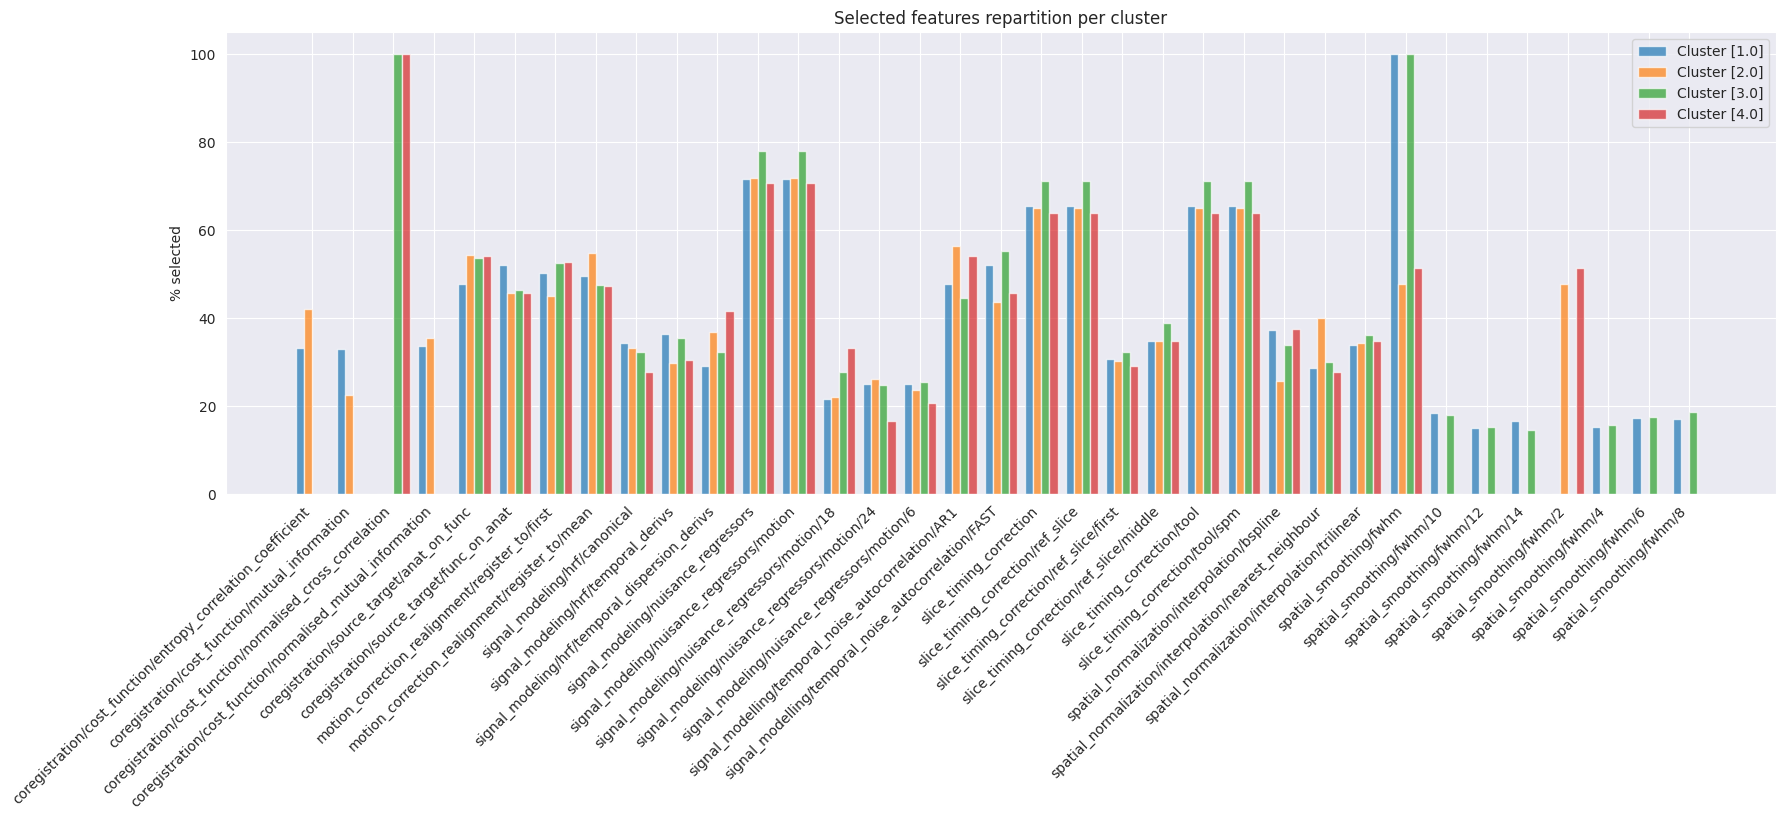

,coregistration/cost_function/entropy_correlation_coefficient,coregistration/cost_function/mutual_information,coregistration/cost_function/normalised_cross_correlation,coregistration/cost_function/normalised_mutual_information,coregistration/source_target/anat_on_func,coregistration/source_target/func_on_anat,motion_correction_realignment/register_to/first,motion_correction_realignment/register_to/mean,signal_modeling/hrf/canonical,signal_modeling/hrf/temporal_derivs,...,spatial_normalization/interpolation/nearest_neighbour,spatial_normalization/interpolation/trilinear,spatial_smoothing/fwhm,spatial_smoothing/fwhm/10,spatial_smoothing/fwhm/12,spatial_smoothing/fwhm/14,spatial_smoothing/fwhm/2,spatial_smoothing/fwhm/4,spatial_smoothing/fwhm/6,spatial_smoothing/fwhm/8
cluster,,,,,,,,,,,,,,,,,,,,,
1.0,33.273381,33.093525,0.0,33.633094,47.841727,52.158273,50.359712,49.640288,34.352518,36.510791,...,28.776978,33.812950,100.000000,18.525180,15.107914,16.726619,0.000000,15.287770,17.266187,17.086331
2.0,42.051282,22.564103,0.0,35.384615,54.358974,45.641026,45.128205,54.871795,33.333333,29.743590,...,40.000000,34.358974,47.692308,0.000000,0.000000,0.000000,47.692308,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,100.0,0.000000,53.672316,46.327684,52.542373,47.457627,32.203390,35.593220,...,29.943503,36.158192,100.000000,18.079096,15.254237,14.689266,0.000000,15.819209,17.514124,18.644068
4.0,0.000000,0.000000,100.0,0.000000,54.166667,45.833333,52.777778,47.222222,27.777778,30.555556,...,27.777778,34.722222,51.388889,0.000000,0.000000,0.000000,51.388889,0.000000,0.000000,0.000000


In [9]:
columns_to_drop = ignored.copy()
columns_to_drop.remove('cluster')
boolean_columns = dataset.select_dtypes(include='bool')
for col in boolean_columns.columns:
    if dataset[col].all():
        columns_to_drop.append(col)
    if (dataset[col] == False).all():
        columns_to_drop.append(col)

filtered = dataset.drop(columns=columns_to_drop)
grouped = filtered.groupby('cluster').mean() * 100
grouped = grouped.sort_index(axis=1)


fig, ax = plt.subplots(figsize=(20, 6))
width = 0.4  # Width of each bar
group_spacing = 0.4  # Space between groups of bars
num_clusters = len(grouped)

# Define x positions for each cluster with additional spacing between groups
x = np.arange(len(grouped.columns)) * (num_clusters * width + group_spacing)

for i, cluster in enumerate(grouped.index):
    cluster_data = grouped.loc[cluster].to_frame().T
    # Offset the x positions for each cluster
    offsets = x + (i - num_clusters / 2) * width + width / 2
    ax.bar(offsets, cluster_data.values[0], alpha=0.7, label=f'Cluster [{cluster}]', width=width)

ax.set_xticks(x)
ax.set_xticklabels(cluster_data.columns, rotation=45, ha='right')
ax.set_ylabel('% selected')
ax.set_title('Selected features repartition per cluster')
ax.legend()

plt.show()

grouped.head(10)

# Convert feature with alternative to enum

In [10]:
str_alternatives = {
    "motion_correction_realignment/register_to" : ["first", "mean"],
    "coregistration/source_target" : ["anat_on_func", "func_on_anat"],
    "coregistration/cost_function" : ["mutual_information", "normalised_mutual_information", "entropy_correlation_coefficient", "normalised_cross_correlation"],
    "spatial_normalization/template" : ["Ixi549Space", "MNI305", "MNI152_linear", "MNI152_nonlinear"],
    "spatial_normalization/algorithm" : ["linear", "nonlinear", "DARTEL"],
    "spatial_normalization/interpolation" : ["nearest_neighbour", "trilinear", "bspline"],
    "spatial_normalization/bias_regularisation" : ["extremely_light", "very_light", "light", "medium", "heavy"],
    "slice_timing_correction/ref_slice" : ["first", "middle"],
    "signal_modeling/hrf" : ["canonical", "temporal_derivs", "temporal_dispersion_derivs"],
    "signal_modelling/temporal_noise_autocorrelation" : ["AR1", "FAST"],
}

num_alternatives = {
    "spatial_normalization/bias_fwhm" : [30, 40, 60, 70, 80, 90, 100, 110, 120,130,140,150],
    "spatial_smoothing/fwhm" : [2, 4, 6, 8, 10, 12, 14],
    "signal_modeling/nuisance_regressors/motion" : [6, 18, 24]
}

bias_regs = {
        'extremely_light': 0.00001,
        'very_light': 0.0001,
        'light': 0.001,
        'medium': 0.01,
        'heavy': 0.1
    }

for index, row in dataset.iterrows():
    for feature, values in num_alternatives.items():
        if row[feature] is False:
            dataset.at[index, feature] = 0
            continue
        for val in values:
            alt = f"{feature}/{val}"
            if row[alt] is True:
                dataset.at[index, feature] = val
    for label, value in bias_regs.items():
        if row[f"spatial_normalization/bias_regularisation/{label}"] is True:
            dataset.at[index, "spatial_normalization/bias_regularisation"] = value

for key in num_alternatives:
    for val in num_alternatives[key]:
        dataset = dataset.drop(f"{key}/{val}",  axis=1)
dataset = dataset.convert_dtypes()
# remove always true columns
boolean_columns = dataset.select_dtypes(include='bool').columns
columns_to_drop = [col for col in boolean_columns if dataset[col].all()]
dataset = dataset.drop(columns=columns_to_drop)
dataset.head()

/home/ymerel/tmp/ipykernel_25514/3860823572.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  dataset.at[index, feature] = 0
/home/ymerel/tmp/ipykernel_25514/3860823572.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  dataset.at[index, feature] = val
/home/ymerel/tmp/ipykernel_25514/3860823572.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  dataset.at[index, feature] = val


,slice_timing_correction/ref_slice/middle,signal_modeling/hrf/temporal_dispersion_derivs,coregistration/cost_function/mutual_information,signal_modeling/nuisance_regressors/comp_cor,signal_modelling/temporal_noise_autocorrelation/FAST,spatial_normalization/algorithm/DARTEL,spatial_normalization/interpolation/bspline,spatial_normalization/bias_regularisation,spatial_normalization/template/MNI152_linear,spatial_normalization/bias_regularisation/extremely_light,...,from_1bd27c273e9f4d9eec9254015501cc8d1eeb109a6cc6ff25c55bfc81f210bb23,from_e2981f97fc870a8fc8a66d9a40c3cc8dcb21be746ad83ecbcc320c8fe4298a73,from_bdab21629030923da17e248d7689fc21eb1abea0d889d3b44c67b4baf6a07de5,from_6363ceb4ad5221e2fd865e8ba9181032905c33814f925c2e960adcd5354485e4,from_2566dc31e9fbea6d892a21f56ecb62ff9df850705b65b17754f772d13f060284,from_6b4189bcd2f407a23e0ebc2d14de55529eaab1b0f5a612ba46b79d019b03cc46,from_c475f858fc2881ef01d1d4b705346000d23d56508ee89dcbf18e173daf48de57,from_5b935ba44056218711fe041d9e5000904a788b010f7c12dd70041a2e5cc4e135,from_05a74cdcbd5faa976b866eec5a083de5e3945cc85a8971c44863127732e7026d,cluster
788,False,False,False,False,False,False,True,False,False,False,...,0.783977,0.781534,0.599326,0.602902,0.912298,0.336283,0.307697,0.286491,0.585972,2
183,False,False,False,False,False,False,True,False,False,False,...,0.041171,0.041733,0.048517,0.018959,0.032519,0.045156,0.061031,0.043576,0.044345,4
997,False,False,False,False,True,False,False,False,False,False,...,0.058683,0.059874,0.07086,0.022124,0.042624,0.062141,0.08679,0.062172,0.05931,4
602,True,True,False,False,True,False,False,False,False,False,...,0.347053,0.351272,0.450279,0.13771,0.251884,0.663299,0.8771,0.479385,0.487748,1
146,False,False,True,False,True,False,False,False,False,False,...,0.807899,0.808281,0.92787,0.330229,0.607472,0.535102,0.538319,0.518996,0.59751,1


# Ref correlations repartition

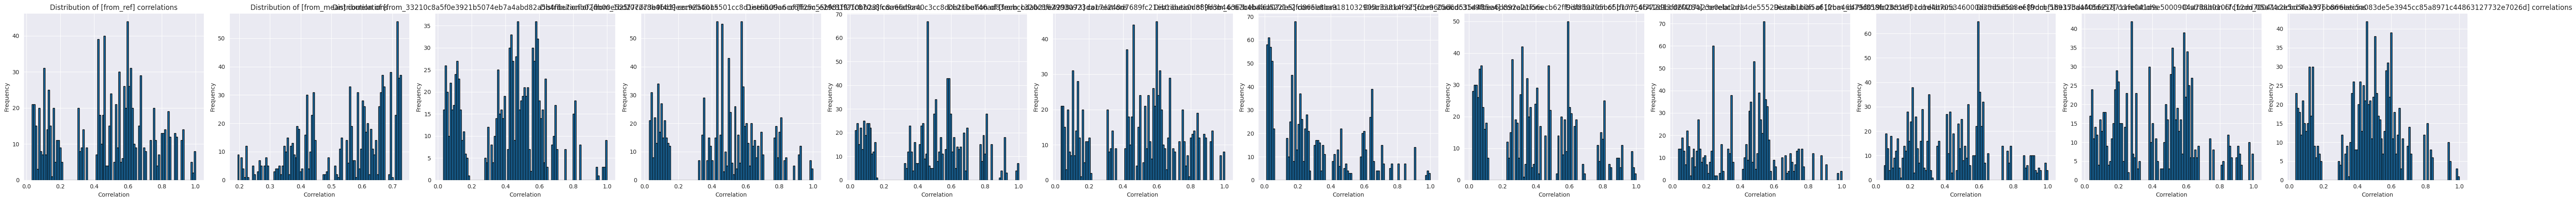

In [11]:
num_plots = len(target_vars)
fig, axes = plt.subplots(ncols=num_plots, figsize=(5 * num_plots, 5))

for i, corr in enumerate(target_vars):
    axes[i].hist(dataset[corr], bins=100, edgecolor='black')
    axes[i].set_title(f'Distribution of [{corr}] correlations')
    axes[i].set_xlabel('Correlation')
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()


# Stats maps QC

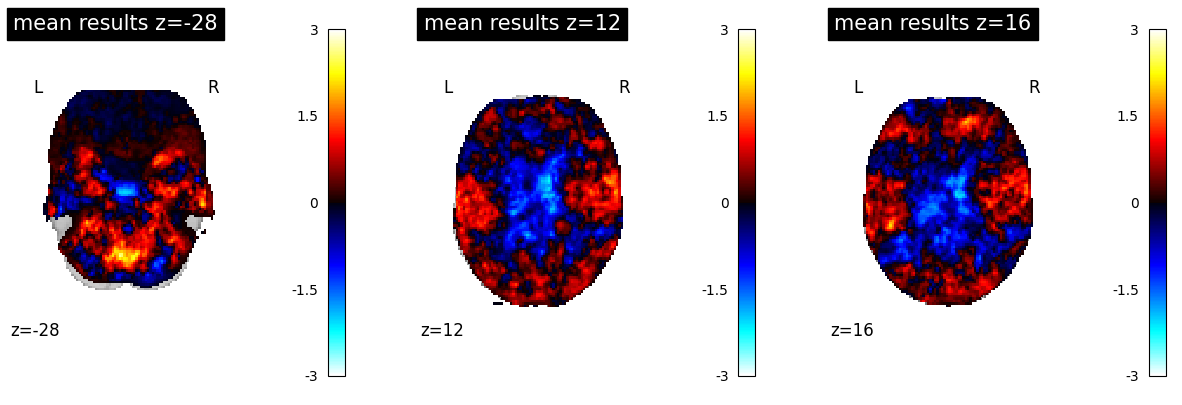

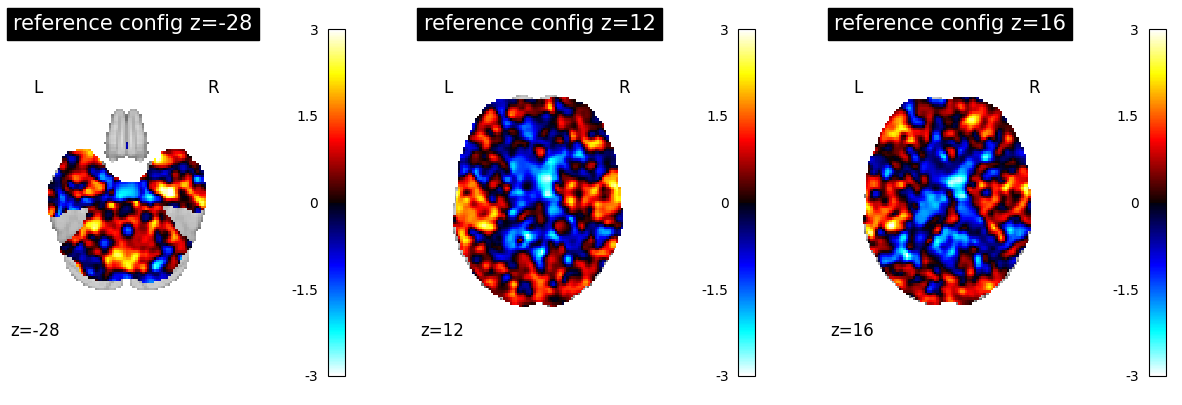

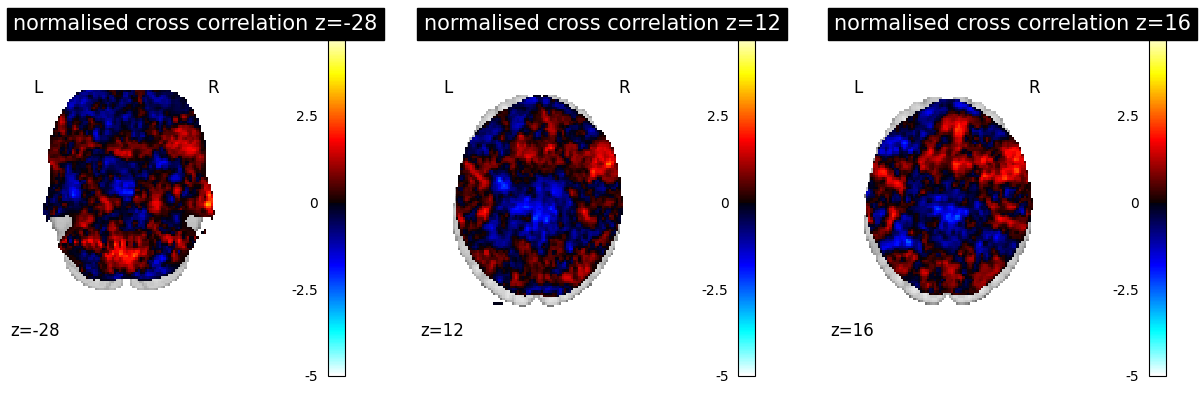

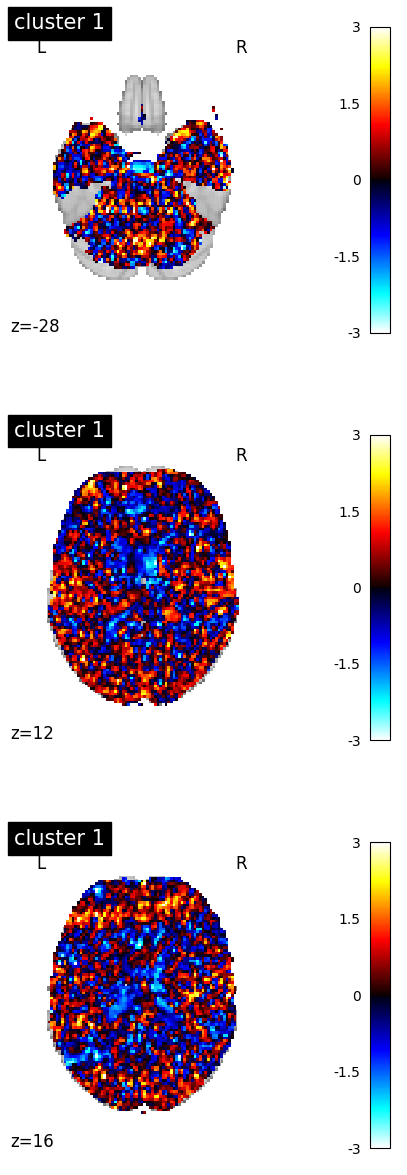

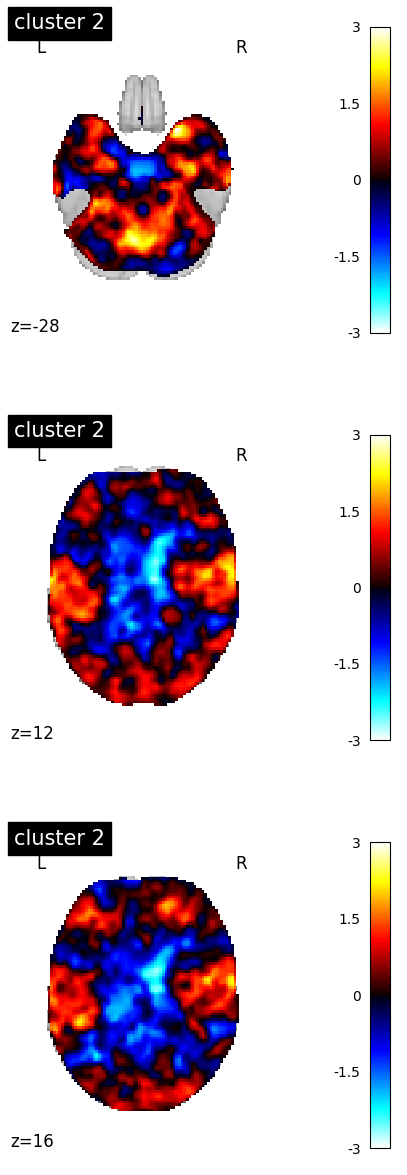

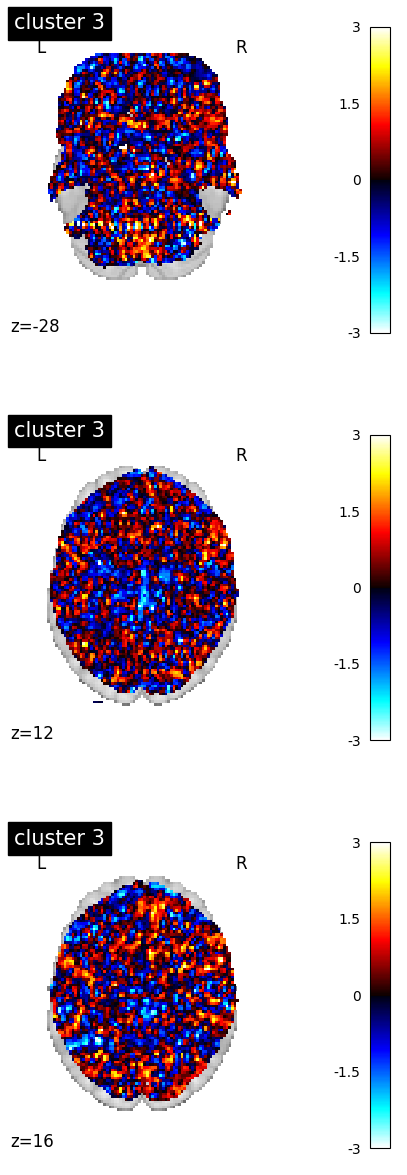

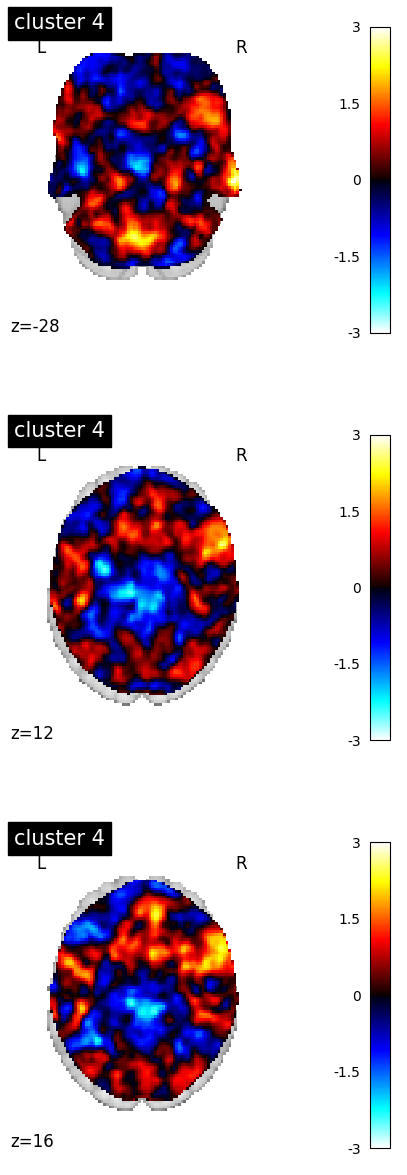

In [12]:
z_coords = [-28, 12, 16]
img = nimg.load_img(os.path.join(basedir, 'mean_result.nii'))
label = 'mean results'
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, z_coord in enumerate(z_coords):
    plotting.plot_stat_map(img, cut_coords=[z_coord], display_mode='z', axes=axes[i], vmin=-3, vmax=3, title=f"{label} z={z_coord}")
plt.show()

img = nimg.load_img(os.path.join(basedir, 'ref', '_subject_id_01', 'result.nii'))
label = 'reference config'
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, z_coord in enumerate(z_coords):
    plotting.plot_stat_map(img, cut_coords=[z_coord], display_mode='z', axes=axes[i], vmin=-3, vmax=3, title=f"{label} z={z_coord}")
plt.show()

# confs_ncc = dataset.loc[dataset["coregistration/cost_function/normalised_cross_correlation"] == True, 'id'].tolist()
# imgs = []
# for path in results:
#     for id in confs_ncc:
#         if id in path:
#             imgs.append(path)
# 
path = os.path.join(basedir, 'ncc_mean_result.nii')
# file_srv.write_mean_image(imgs, path)
img = nimg.load_img(path)
label = 'normalised cross correlation'
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, z_coord in enumerate(z_coords):
    plotting.plot_stat_map(img, cut_coords=[z_coord], display_mode='z', axes=axes[i], vmin=-5, vmax=5, title=f"{label} z={z_coord}")
plt.show()

id_by_cluster = dataset.groupby('cluster')['id'].apply(list).to_dict()
for cluster, configs in id_by_cluster.items():
    # imgs = []
    # for path in results:
    #     for config in configs:
    #         if config in path:
    #             imgs.append(path)
    path = os.path.join(basedir, f'cluster_{cluster}_mean_result.nii')
    # file_srv.write_mean_image(imgs, path)
    img = nimg.load_img(path)
    label = f'cluster {cluster}'
    fig, axes = plt.subplots(3, 1, figsize=(5, 15))
    for i, z_coord in enumerate(z_coords):
        plotting.plot_stat_map(img, cut_coords=[z_coord], display_mode='z', axes=axes[i], vmin=-3, vmax=3, title=f"{label}")
    plt.show()

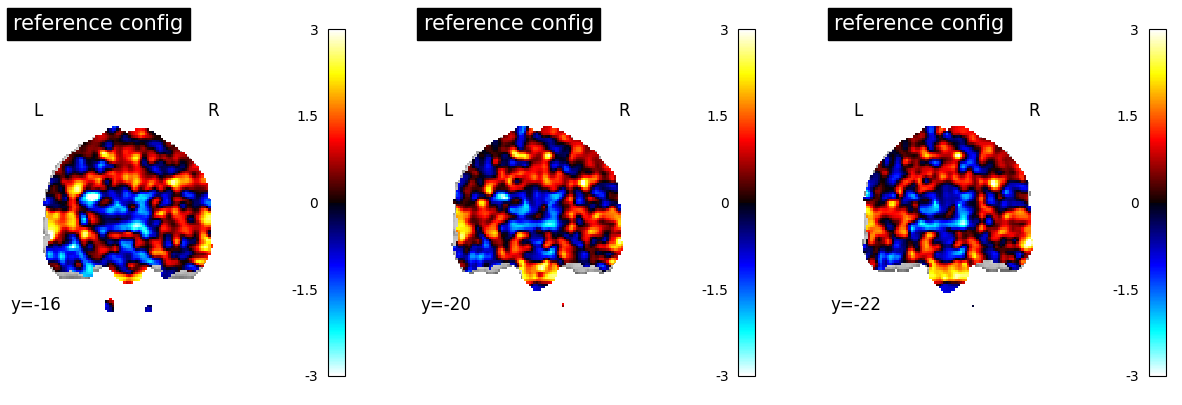

In [13]:
y_coords = [-16, -20, -22]
img = nimg.load_img(os.path.join(basedir, 'ref', '_subject_id_01', 'result.nii'))
label = 'reference config'
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, y_coord in enumerate(y_coords):
    plotting.plot_stat_map(img, cut_coords=[y_coord], display_mode='y', axes=axes[i], vmin=-3, vmax=3, title=f"{label}")
plt.show()

# Fit regressor decision tree model for all correlations metrics
- Try to predict the correlations for each configuration
- mean of correlations is computed independently for each train, test subset

Fit model for [from_ref]
Iteration 1, Current train size: 0.1
Iteration 1, Current train size: 0.2
Iteration 1, Current train size: 0.3
Iteration 1, Current train size: 0.4
Iteration 1, Current train size: 0.5
Iteration 1, Current train size: 0.6
Iteration 1, Current train size: 0.7
Iteration 2, Current train size: 0.1
Iteration 2, Current train size: 0.2
Iteration 2, Current train size: 0.3
Iteration 2, Current train size: 0.4
Iteration 2, Current train size: 0.5
Iteration 2, Current train size: 0.6
Iteration 2, Current train size: 0.7
Iteration 3, Current train size: 0.1
Iteration 3, Current train size: 0.2
Iteration 3, Current train size: 0.3
Iteration 3, Current train size: 0.4
Iteration 3, Current train size: 0.5
Iteration 3, Current train size: 0.6
Iteration 3, Current train size: 0.7
Iteration 4, Current train size: 0.1
Iteration 4, Current train size: 0.2
Iteration 4, Current train size: 0.3
Iteration 4, Current train size: 0.4
Iteration 4, Current train size: 0.5
Iteration 4, 

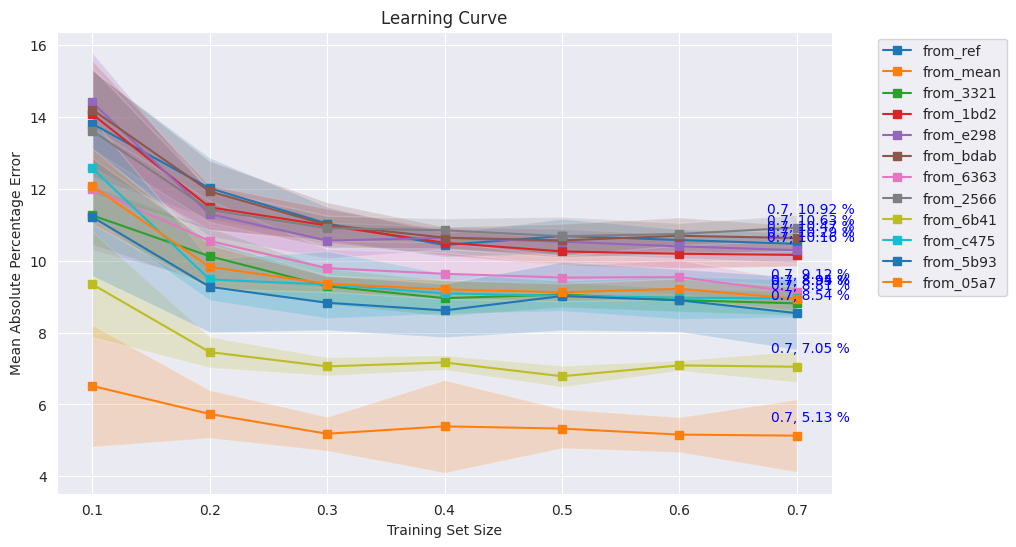

In [19]:
X = dataset['id']
y = dataset['id']
results = []
feat_importances = []
train_sizes = np.linspace(0.1, 0.7, 7).tolist()
num_iterations = 10

plt.figure(figsize=(10, 6))

for metric in target_vars:
    print(f"Fit model for [{metric}]")
    
    from_mean = (metric == 'from_mean')

    # Initialize matrix to store results
    mape_matrix = np.zeros((num_iterations, len(train_sizes)))

    for i in range(num_iterations):
        test_scores = []
        for train_size in train_sizes:
            train_size = round(train_size, 1)
            print(f"Iteration {i + 1}, Current train size: {train_size}")

            X_id_train, X_id_test, y_id_train, y_id_test = train_test_split(X, y, train_size=train_size)
            
            if from_mean:
                X_train = pd.read_csv(os.path.join(basedir, f'sub_dataset_{int(train_size*1000)}_train_{i+1}.csv'), delimiter=';')
                X_train['cluster'] = pd.Series([], dtype='float64')
            else:
                X_train = clusterize(X_id_train, 4)[0]
            y_train = X_train[metric]
            X_train = X_train.drop(columns=ignored)
            if from_mean:
                X_test = pd.read_csv(os.path.join(basedir, f'sub_dataset_{int(1000 - (train_size*1000))}_test_{i+1}.csv'), delimiter=';')
                X_test['cluster'] = pd.Series([], dtype='float64')
            else:
                X_test = clusterize(X_id_test, 4)[0]
            y_test = X_test[metric]
            X_test = X_test.drop(columns=ignored)

            # Train model
            regressor = DecisionTreeRegressor(max_depth=4)
            regressor.fit(X_train, y_train)

            y_pred = regressor.predict(X_test)
            mape = mean_absolute_percentage_error(y_test, y_pred)
            score = mape * 100  # Negative because it's a loss metric
            test_scores.append(score)

            if train_size == 0.7 and i == 0:
                dot_data = tree.export_graphviz(regressor, out_file=None,
                                                feature_names=X_train.columns.values,
                                                filled=True, rounded=True,
                                                special_characters=True,
                                                leaves_parallel=True, proportion=True)
                graph = graphviz.Source(dot_data)
                graph.render(f"{metric}")

                features = dataset.drop(columns=ignored).columns
                importances = regressor.feature_importances_
                for j, feat in enumerate(features):
                    feat_importances.append((metric, feat, importances[j]))

        # Store results in matrix
        mape_matrix[i, :] = test_scores

    # Calculate mean and standard deviation
    mean_mape = np.mean(mape_matrix, axis=0)
    std_mape = np.std(mape_matrix, axis=0)

    # Plotting
    plt.plot(train_sizes, mean_mape, marker='s', label=f'{metric[:9]}')
    # Annotate the last point
    plt.annotate(f'{mean_mape[-1]:.2f} %',
             (train_sizes[-1], mean_mape[-1]),
             textcoords="offset points",
             xytext=(10, 10),
             ha='center',
             fontsize=10,
             color='red')
    plt.fill_between(train_sizes, mean_mape - std_mape, mean_mape + std_mape, alpha=0.2)
    results.append((metric, train_sizes, mean_mape, std_mape))

# Place the legend outside the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Absolute Percentage Error')
plt.title('Learning Curve')
plt.grid(True)
plt.show()

# Fit classifier decision tree model for clusters
- Try to predict the cluster of each configuration
- Clustering is recomputed independently for test, train subsets

Fit model for [cluster]
Iteration 1, Current train size: 0.1
              precision    recall  f1-score   support

           1       1.00      0.93      0.96       494
           2       0.84      1.00      0.91       176
           3       0.90      0.81      0.85       162
           4       0.63      0.78      0.70        68

    accuracy                           0.91       900
   macro avg       0.84      0.88      0.86       900
weighted avg       0.92      0.91      0.91       900

Iteration 1, Current train size: 0.2
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       440
           2       1.00      1.00      1.00       150
           3       0.90      1.00      0.95       135
           4       1.00      0.80      0.89        75

    accuracy                           0.98       800
   macro avg       0.97      0.95      0.96       800
weighted avg       0.98      0.98      0.98       800

Iteration 1, Current train size:

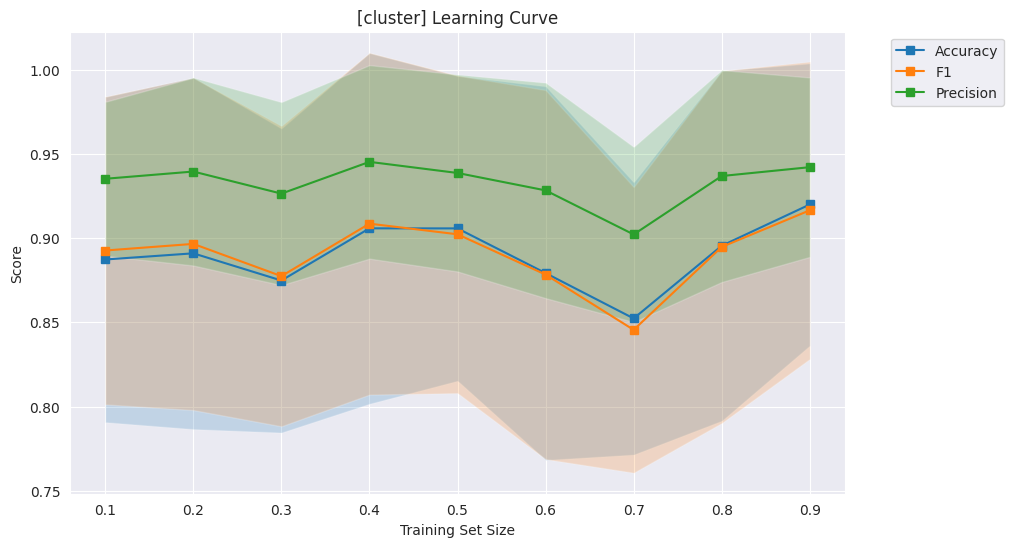

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, classification_report
import graphviz

# Assuming `clusterize`, `dataset`, and `ignored` are defined elsewhere in your code

metric = 'cluster'
results = []
feat_importances = []

print(f"Fit model for [{metric}]")

X = dataset['id']
y = dataset['id']

train_sizes = np.linspace(0.1, 0.7, 7).tolist()
num_iterations = 10

# Initialize matrices to store results
accuracy_matrix = np.zeros((num_iterations, len(train_sizes)))
f1_matrix = np.zeros((num_iterations, len(train_sizes)))
precision_matrix = np.zeros((num_iterations, len(train_sizes)))

for iteration in range(num_iterations):
    test_scores_acc = []
    test_scores_f1 = []
    test_scores_prec = []

    for train_size in train_sizes:
        train_size = round(train_size, 1)
        print(f"Iteration {iteration + 1}, Current train size: {train_size}")
        X_id_train, X_id_test, y_id_train, y_id_test = train_test_split(X, y, train_size=train_size)

        X_train = clusterize(X_id_train, 4)
        y_train = X_train[0]['cluster']
        X_train = X_train[0].drop(columns=ignored)

        X_test = clusterize(X_id_test, 4)
        y_test = X_test[0]['cluster']
        X_test = X_test[0].drop(columns=ignored)

        classifier = DecisionTreeClassifier(random_state=42)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        print(classification_report(y_test, y_pred, target_names=['1', '2', '3', '4']))

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')

        test_scores_acc.append(accuracy)
        test_scores_f1.append(f1)
        test_scores_prec.append(precision)

        if train_size == 0.7 and iteration == 0:
            dot_data = tree.export_graphviz(classifier, out_file=None,
                                             feature_names=X_train.columns.values,
                                             filled=True, rounded=True,
                                             special_characters=True,
                                             leaves_parallel=True, proportion=True)
            graph = graphviz.Source(dot_data)
            graph.render(f"{metric}")

            features = dataset.drop(columns=ignored).columns
            importances = classifier.feature_importances_
            for i, feat in enumerate(features):
                feat_importances.append((metric, feat, importances[i]))

    # Store results in matrices
    accuracy_matrix[iteration, :] = test_scores_acc
    f1_matrix[iteration, :] = test_scores_f1
    precision_matrix[iteration, :] = test_scores_prec

# Calculate mean and standard deviation
mean_accuracy = np.mean(accuracy_matrix, axis=0)
std_accuracy = np.std(accuracy_matrix, axis=0)
mean_f1 = np.mean(f1_matrix, axis=0)
std_f1 = np.std(f1_matrix, axis=0)
mean_precision = np.mean(precision_matrix, axis=0)
std_precision = np.std(precision_matrix, axis=0)


# Plotting
mean_score = mean_accuracy
std_score = std_accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, mean_score, marker='s', label=f'Accuracy')
plt.fill_between(train_sizes, mean_score - std_score, mean_score + std_score, alpha=0.2)
mean_score = mean_f1
std_score = std_f1
plt.plot(train_sizes, mean_score, marker='s', label=f'F1')
plt.fill_between(train_sizes, mean_score - std_score, mean_score + std_score, alpha=0.2)
mean_score = mean_precision
std_score = std_precision
plt.plot(train_sizes, mean_score, marker='s', label=f'Precision')
plt.fill_between(train_sizes, mean_score - std_score, mean_score + std_score, alpha=0.2)

plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title(f'[{metric}] Learning Curve')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


# Fit classifier decision tree model for clusters
- Try to predict the cluster of each configuration
- Clustering is recomputed independently for test, train subsets

In [84]:
results_df = pd.DataFrame(results, columns=['Metric', 'test_scores_acc', 'test_scores_f1', 'test_scores_prec'])
results_df.head(14)

,Metric,test_scores_acc,train_scores_acc,test_scores_f1,train_scores_f1,test_scores_prec,train_scores_prec
0,cluster,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.98, 0.0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.97976923...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.98285714...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"


In [58]:
importance_df = pd.DataFrame(feat_importances, columns=['Metric', 'Feature', 'Importance']).sort_values(by='Importance', ascending=False)
importance_df = importance_df[importance_df['Importance'] != 0.00000]
importance_df.head(100)

,Metric,Feature,Importance
445,from_05a74cdcbd5faa976b866eec5a083de5e3945cc85...,coregistration/cost_function/normalised_cross_...,0.754221
141,from_1bd27c273e9f4d9eec9254015501cc8d1eeb109a6...,coregistration/cost_function/normalised_cross_...,0.752760
179,from_e2981f97fc870a8fc8a66d9a40c3cc8dcb21be746...,coregistration/cost_function/normalised_cross_...,0.744844
27,from_ref,coregistration/cost_function/normalised_cross_...,0.740938
217,from_bdab21629030923da17e248d7689fc21eb1abea0d...,coregistration/cost_function/normalised_cross_...,0.733508
103,from_33210c8a5f0e3921b5074eb7a4abd82a5b4f6e7ac...,coregistration/cost_function/normalised_cross_...,0.720458
65,from_mean,coregistration/cost_function/normalised_cross_...,0.632604
331,from_6b4189bcd2f407a23e0ebc2d14de55529eaab1b0f...,coregistration/cost_function/normalised_cross_...,0.620445
293,from_2566dc31e9fbea6d892a21f56ecb62ff9df850705...,coregistration/cost_function/normalised_cross_...,0.583448
256,from_6363ceb4ad5221e2fd865e8ba9181032905c33814...,spatial_smoothing/fwhm,0.566945


# Mean absolute percentage error per metric

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

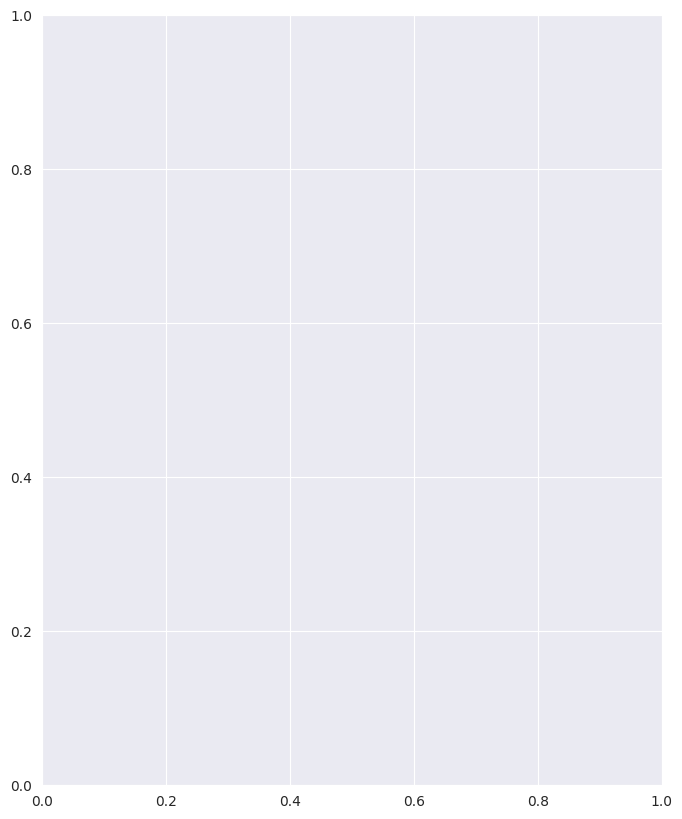

In [59]:
# Plotting
fig, ax = plt.subplots(figsize=(8, 10))
bar_width = 0.2
index = np.arange(len(results_df['Metric']))

# Plot bars for each metric
bar3 = ax.bar(index + 2 * bar_width, results_df['MAPE'], bar_width, label='Mean absolute percentage error (MAPE)')

# Adding labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of MAPE for metrics')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(results_df['Metric'])
ax.legend()

# Display the plot
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Learning curves of fitted models

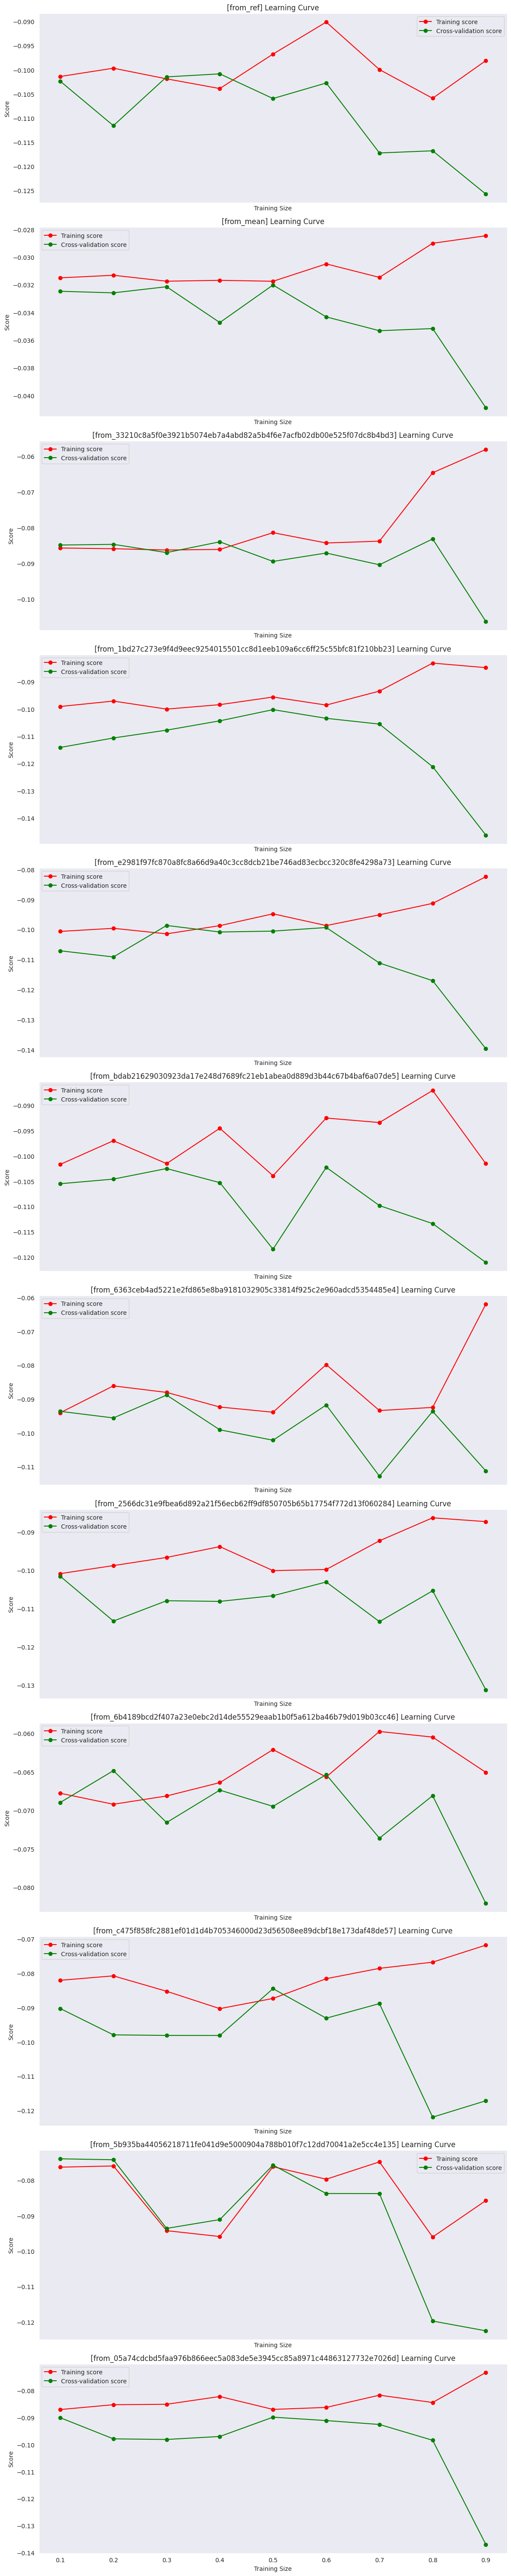

In [60]:
# Plotting
num_metrics = len(results_df)
fig, axes = plt.subplots(nrows=num_metrics, figsize=(num_metrics, num_metrics * 5), sharex=True)

for i, (index, row) in enumerate(results_df.iterrows()):
    ax = axes[i]
    ax.plot(train_sizes, row['train_scores'], 'o-', color='r', label='Training score')
    ax.plot(train_sizes, row['test_scores'], 'o-', color='g', label='Cross-validation score')
    # ax.fill_between(train_sizes, -row['train_mean'] - row['train_std'], -row['train_mean'] + row['train_std'], alpha=0.1, color='r')
    # ax.fill_between(train_sizes, -row['test_mean'] - row['test_std'], -row['test_mean'] + row['test_std'], alpha=0.1, color='g')
    ax.grid()
    ax.set_xlabel('Training Size')
    ax.set_ylabel('Score')
    ax.set_title(f'[{row["Metric"]}] Learning Curve')
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

# Computational cost

In [18]:
with open('/home/ymerel/storage/results/auditory/jobs.json', 'r') as file:
        data = json.load(file)

In [19]:
jobs = []
run_hours = 0
post_hours = 0
times = []
for id, job in data['jobs'].items():
    if job['owner'] == 'ymerel' and job['state'] == 'Terminated':
        if job['command'] == '/home/ymerel/fmri-conf-runner/run_configs.sh':
            times.append((job['stop_time'] - job['start_time']) / 60)
            run_hours += (job['stop_time'] - job['start_time']) / 3600
        if job['command'] == '/home/ymerel/fmri-conf-runner/postprocess.sh':
            post_hours += (job['stop_time'] - job['start_time']) / 3600
        jobs.append(job)
print(f"[pipelines] Total runtime (h) : {run_hours}")
print(f"[pipelines] Runtime per pipelines (min) : {(run_hours / 1000)*60}")
print(f"[postprocessing] Total runtime (h) : {post_hours}")

[pipelines] Total runtime (h) : 49.05666666666668
[pipelines] Runtime per pipelines (min) : 2.943400000000001
[postprocessing] Total runtime (h) : 28.629166666666663
